# Deep Learning
## Formative assessment
### Week 8: Normalising flows I: Autoregressive flows

#### Instructions

In this notebook, you will write code to implement and train an autoregressive normalising flow density estimation model.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset.

In [2]:
#### PACKAGE IMPORTS ####

# Run this cell to import all required packages. 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

<img src="figures/mlds.png" title="MLDS" style="width: 600px;"/>  
  
#### The MLDS dataset

In this assignment, you will use a synthetic point cloud dataset to train an autoregressive normalising flow model. The dataset consists of 5,376 points in two-dimensions.

Your goal is to build and train a masked autoregressive flow as a density estimation model for this point cloud dataset.

#### Load the dataset

In [5]:
# Load the data into a numpy array

dataset = np.load(Path("./data/mlds.npy"))

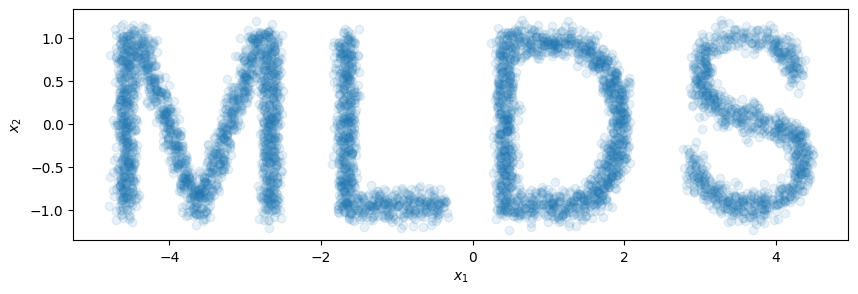

In [6]:
# View the data

plt.figure(figsize=(10, 3))
plt.scatter(dataset[:, 0], dataset[:, 1], alpha=0.1)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

Complete the following `get_dataset` function to load and prepare the data into a `tf.data.Dataset` object.

* The function takes `data_array`, `shuffle_buffer_size` and `batch_size` as arguments
  * `data_array` is a numpy array of shape `(num_examples, 2)`
  * `shuffle_buffer_size` and `batch_size` are integers
* You should load the array into a Dataset object and process as follows:
  * Shuffle the Dataset with a buffer size of `shuffle_buffer_size`
  * Batch the Dataset with `batch_size`
  * Prefetch the Dataset with `tf.data.AUTOTUNE`
* Your function should then return the Dataset

In [9]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_dataset(data_array, shuffle_buffer_size, batch_size):
    """
    This function should create a Dataset object as described above.
    The function should then return the Dataset object.
    """
    data = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(dataset))
    data = data.shuffle(shuffle_buffer_size).batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data
    

In [10]:
# Use your function to create the Datasets

train_ds = get_dataset(dataset, shuffle_buffer_size=500, batch_size=512)
train_ds.element_spec

TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)

#### Build the normalising flow model
We will use the Masked Autoregressive Flow (MAF) to model the MLDS dataset. Recall that MAF is an implementation of the Gaussian-conditional autoregressive flow:

$$
p(x_i \mid x_{1:i-1}) = N(x_i \mid \mu_i, \sigma_i^2),\qquad i=1,\ldots,D
$$

$$\left.
\begin{array}{rcl}
\mu_i & = & f_{\mu_i}(x_{1:i-1})\\
\sigma_i & = & f_{\sigma_i}(x_{1:i-1})
\end{array}\right\}\qquad i = 1,\ldots,D
$$

where $D$ is the dimension of the data example $x$. The forward and inverse transformations are given as follows:

$$
\text{Forward transformation:} \quad x_i = f_{\sigma_i}(x_{1:i-1}) z_i + f_{\mu_i}(x_{1:i-1})
$$</br>
$$
\text{Inverse transformation:} \quad z_i = \frac{x_i - f_{\mu_i}(x_{1:i-1})}{f_{\sigma_i}(x_{1:i-1})}
$$

where $z_i$ is distributed according to a base distribution, typically a standard Normal distribution.

In the MAF, the functions $f_{\mu_i}$ and $f_{\sigma_i}$ $(i=1,\ldots,D)$ are modelled with MADE networks.

We will start by defining a suitable base distribution. You should complete the following `base_distribution` function, according to the following specification:

* The function should define a `tfd.Distribution` object
* The distribution should be a 2-D Gaussian with zero mean and covariance matrix $\sigma^2I$, where $\sigma=2$
* The `batch_shape` of the Distribution object should be empty, and the `event_shape` should be `[2]`
* The function should then return the `tfd.Distribution` object

In [11]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def base_distribution():
    """
    This function should define a tfd.Distribution object as described above.
    The function should then return the Distribution object.
    """
    normal = tfd.MultivariateNormalDiag(loc = [0,0], scale_diag = [2,2])
    return normal
    

In [12]:
# Use your function to define the base distribution

base = base_distribution()
base

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

You should now complete the following function `maf_flow` to define the `TransformedDistribution` object for the MAF normalising flow.

* The function takes `base_dist`, `num_layers` and `hidden_units` as arguments
* `base_dist` is a `tfd.Distribution` object to be used as the base distribution, with empty `batch_shape` and `event_shape=[2]`
* `hidden_units` is a list of integers
* `num_layers` is an integer to define the number of steps of flow
* Each step of flow should consist of a MAF bijector, where the autoregressive transformation is defined by a MADE network, followed by a permutation of the input dimensions
  * The MADE network should have number and width of hidden layers defined by `hidden_units`
  * The MADE network should use a ReLU activation, and output a mean and log-scale parameter for each input dimension
  * After each MAF bijector, the order of the 2 event dimensions should be permuted
* This sequence of bijectors should be used to define a `TransformedDistribution` to transform `base_dist`
* The function should then return the `TransformedDistribution` object

In [13]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def maf_flow(base_dist, num_layers, hidden_units):
    """
    This function should define a tfd.TransformedDistribution object as described above.
    The function should then return the TransformedDistribution object.
    """
    def get_maf_bijector():
        made = tfb.AutoregressiveNetwork(params=2, hidden_units=hidden_units, activation='relu')
        return tfb.MaskedAutoregressiveFlow(made)
    maf_bijs = []
    for _ in range(num_layers):
        maf_bijs.append(get_maf_bijector())
        #swap order of variables each iteration
        #this permutes the indices of the incoming tensor, since the bijector returns in reverse order
        maf_bijs.append(tfb.Permute([1, 0]))
    maf_bijector = tfb.Chain(list(reversed(maf_bijs)))
    maf = tfd.TransformedDistribution(base_dist, maf_bijector)
    return maf
    

In [27]:
# Define the MAF TransformedDistribution
    
maf = maf_flow(base, num_layers=6, hidden_units=[128, 128, 128])

#### Train the MAF model

We will use a custom training loop to train the normalising flow. You should now complete the following `train_model` function to perform the custom training loop. 

* The function takes `maf_model`, `opt`, `training_dataset`, `epochs` and `loss_metric` as arguments
* The custom training loop should consist of an outer loop for the epochs, that runs for `epochs` number of times
* At the start of each epoch, the metric state should be reset using the `reset_state` method
* Within each epoch, the function should loop over `training_dataset` to pull batches of data
* For each batch, it should compute the loss and gradients and use the `opt` optimizer to update the model parameters
  * For each batch, the metric should be updated, using the `update_state` method
* The average loss over each epoch should each be stored in a list of floats
  * The average loss can be retrieved from the metrics at the end of the epoch using the `result` method
* The function should return a list of floats for the average loss per epoch

In [28]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def train_model(maf_model, opt, training_dataset, epochs, loss_metric):
    """
    This function should run the custom training loop as described above.
    The function should return a list with the average loss per epoch.
    """
    epoch_losses = []
    
    @tf.function
    def train_step(batch):
        with tf.GradientTape() as tape:
            nll = -tf.reduce_mean(maf_model.log_prob(batch)) 
            #these two can be in or out of the tape with bit
            grads = tape.gradient(nll, maf_model.trainable_variables)
            opt.apply_gradients(zip(grads, maf_model.trainable_variables))
        return nll
    
    for epoch in range(epochs):
        loss_metric.reset_state()
        
        for train_batch in training_dataset:
            loss = train_step(train_batch)
            loss_metric.update_state(loss)
            
        avg_epoch_loss = float(loss_metric.result().numpy())
        epoch_losses.append(avg_epoch_loss)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: loss - {avg_epoch_loss:.4f}")
    
    return epoch_losses

In [29]:
# Define the metric and optimizer to be used in the above function

mean_metric = tf.keras.metrics.Mean()
rmsprop = tf.keras.optimizers.RMSprop(rho=0.99)

In [30]:
# Run the custom training loop

losses = train_model(maf, rmsprop, train_ds, 800, mean_metric)

Epoch 0: loss - 4.3435
Epoch 50: loss - 3.0064
Epoch 100: loss - 2.8794
Epoch 150: loss - 2.8205
Epoch 200: loss - 2.8104
Epoch 250: loss - 2.6701
Epoch 300: loss - 2.6980
Epoch 350: loss - 2.6743
Epoch 400: loss - 2.6695
Epoch 450: loss - 2.7361
Epoch 500: loss - 2.6594
Epoch 550: loss - 2.6729
Epoch 600: loss - 2.5901
Epoch 650: loss - 2.5268
Epoch 700: loss - 2.5882
Epoch 750: loss - 2.5045


_Note: training normalising flow models can sometimes be numerically unstable if the NLL calculation happens to be very high for a given batch of data and model parameter settings. In this case you might see the loss go to NaN. If that happens, re-initialise the model and run the training again._

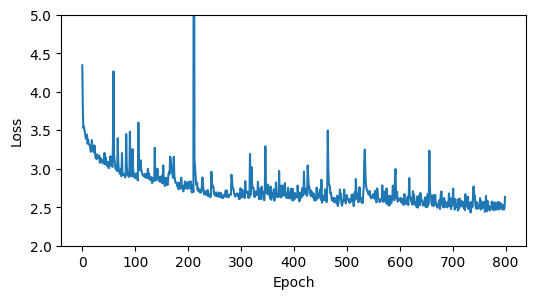

In [31]:
# Plot the training loss

plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(2.0, 5.0)
plt.show()

#### View some samples

The following code will draw 2,000 samples from your MAF normalising flow model and display them as a scatter plot. If the model has trained well, this should be a reasonable approximation of the MLDS point cloud dataset.

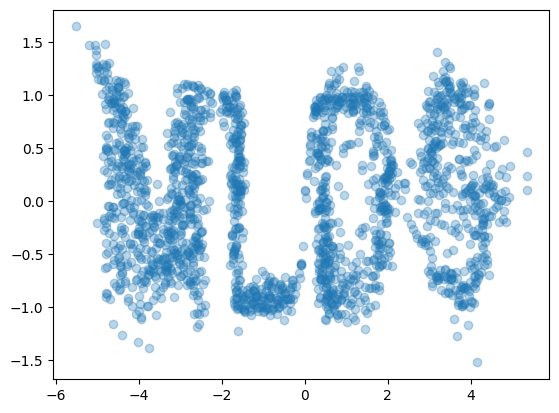

In [32]:
# Draw samples and display them

maf_samples = maf.sample(2000).numpy()
plt.scatter(maf_samples[:, 0], maf_samples[:, 1], alpha=0.3)

We will visualise the transformations contained in each of the steps of flow of our normalising model, where each step consists of a MAF bijector followed by a permutation.

You should now complete the following function `layer_transformations` to compute and store the transformations after each step of flow.

* The function takes `maf_model` and `base_dist_samples` as arguments
  * `maf_model` is a `TransformedDistribution` object as defined by your `maf_flow` function
  * This MAF flow has a number of steps of flow, each consisting of a MAF bijector followed by a permutation bijector
  * `base_dist_samples` is a Tensor of shape `(num_samples, 2)`
* Your function should pass `base_dist_samples` through the individual bijectors of `maf_model`
  * After each step of flow, append the transformed samples to a list as a numpy array
* Your function should then return the list of numpy arrays
  * Each array should have shape `(num_samples, 2)`
  * There should be one array for each step of flow in `maf_model`
  
_Hint: the bijectors defining a `TransformedDistribution` can be accessed through its `bijector` property. Similarly, a `tfb.Chain` bijector has a `bijectors` property which contains the list of bijectors used to define it. Note that `tfb.Chain` transforms its inputs through this list of bijectors in reverse order._

In [33]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def layer_transformations(maf_model, base_dist_samples):
    """
    This function should compute and store the transformed samples as above.
    The function should return a list of numpy arrays.
    """
    transforms = []

    h = base_dist_samples
    #have to reverse since the first transformation is at the end of the list like matrices
    for i, bij in enumerate(reversed(maf_model.bijector.bijectors)):
        h = bij.forward(h)
        #dont want permutations
        if (i+1) % 2 == 0:
            transforms.append(h.numpy())
            
    return transforms

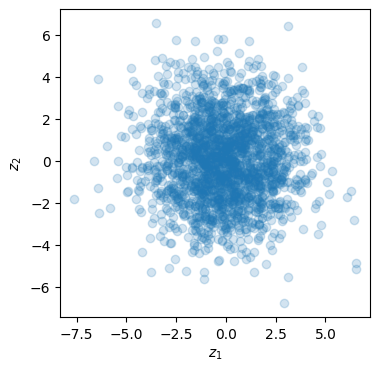

In [34]:
# Compute and visualise some samples from the base distribution

base_samples = base.sample(2000)
plt.figure(figsize=(4, 4))
plt.scatter(base_samples.numpy()[:, 0], base_samples.numpy()[:, 1], alpha=0.2)
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()

In [35]:
# Use your function to compute the transformations from your MAF normalising flow

maf_transforms = layer_transformations(maf, base_samples)

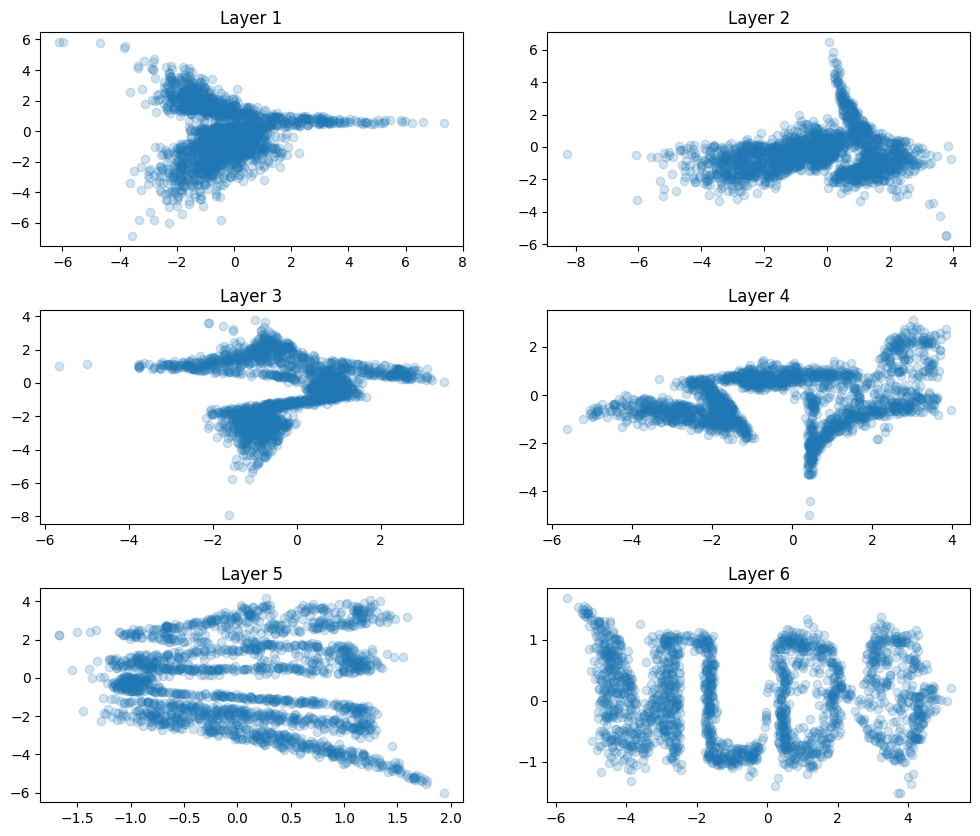

In [36]:
# Visualise the layer transformations

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.3)
for i, ax in enumerate(axes.flatten()):
    ax.set_title(f"Layer {i+1}")
    transform = maf_transforms[i]
    ax.scatter(transform[:, 0], transform[:, 1], alpha=0.2)

#### Try a different base distribution

There are several hyperparameter settings for our MAF flow that you could try varying to see if it improves performance. Below we will try experimenting with a different base distribution.

You should now complete the following `gaussian_mixture` function to define a mixture of Gaussians to use for our base distribution.

* The function takes no arguments as input. It should define a [`tfd.MixtureSameFamily`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily) object
* The mixture should consist of four 2-d Gaussian distributions, each with equal mixture weight
* The means of each Gaussian component should as follows:
  * Component 1: $[-3.6, 0]$
  * Component 2: $[-1.2, 0]$
  * Component 3: $[1, 0]$ 
  * Component 4: $[3.7, 0]$
* Each Gaussian component should have a diagonal covariance matrix with diagonal elements $[0.16, 0.16]$
* The function should then return the `MixtureSameFamily` Distribution object

In [37]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def gaussian_mixture():
    """
    This function should define a tfd.MixtureSameFamily object as described above.
    The function should then return the Distribution object.
    """
    gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              probs=[0.25, 0.25, 0.25, 0.25]),
          components_distribution=tfd.MultivariateNormalDiag(
            loc=[[-3.6, 0], [-1.2, 0.], [1., 0], [3.7, 0]],
            scale_diag=[0.4, 0.4]))
    return gm

In [38]:
# Use your function to define a new base distribution

base_gm = gaussian_mixture()

In [39]:
# Define a new MAF TransformedDistribution
    
maf2 = maf_flow(base_gm, num_layers=6, hidden_units=[128, 128, 128])

In [40]:
# Train the new MAF model

mean_metric = tf.keras.metrics.Mean()
rmsprop = tf.keras.optimizers.RMSprop(rho=0.99)
losses2 = train_model(maf2, rmsprop, train_ds, 800, mean_metric)

Epoch 0: loss - 5.3418
Epoch 50: loss - 2.9188
Epoch 100: loss - 2.8019
Epoch 150: loss - 2.7765
Epoch 200: loss - 2.6543
Epoch 250: loss - 2.6709
Epoch 300: loss - 2.5750
Epoch 350: loss - 2.5723
Epoch 400: loss - 2.6998
Epoch 450: loss - 2.5101
Epoch 500: loss - 2.6407
Epoch 550: loss - 2.6612
Epoch 600: loss - 2.5641
Epoch 650: loss - 2.4319
Epoch 700: loss - 2.4858
Epoch 750: loss - 2.4179


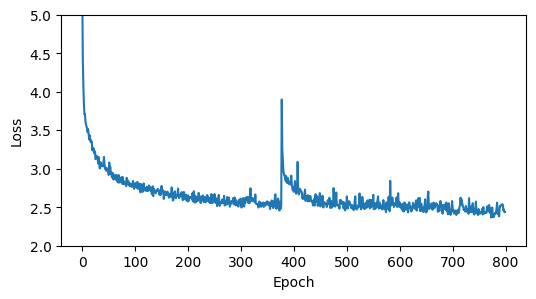

In [41]:
# Plot the training loss

plt.figure(figsize=(6, 3))
plt.plot(losses2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(2.0, 5.0)
plt.show()

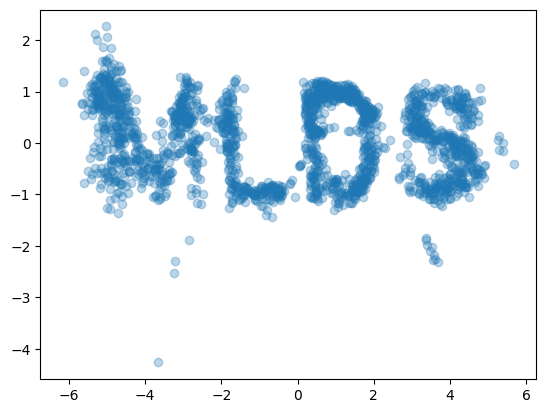

In [42]:
# Draw samples and display them

maf_samples2 = maf2.sample(2000).numpy()
plt.scatter(maf_samples2[:, 0], maf_samples2[:, 1], alpha=0.3)

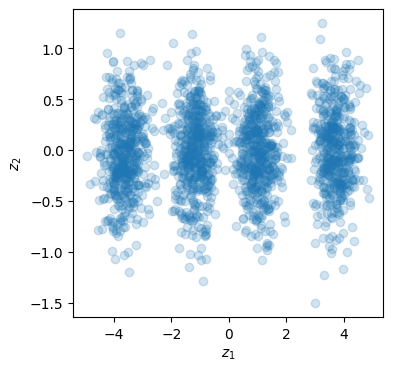

In [43]:
# Compute and visualise some samples from the Gaussian mixture base distribution

base_gm_samples = base_gm.sample(2000)
plt.figure(figsize=(4, 4))
plt.scatter(base_gm_samples.numpy()[:, 0], base_gm_samples.numpy()[:, 1], alpha=0.2)
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()

In [44]:
# Use your function to compute the transformations from your new MAF normalising flow

maf2_transforms = layer_transformations(maf2, base_gm_samples)

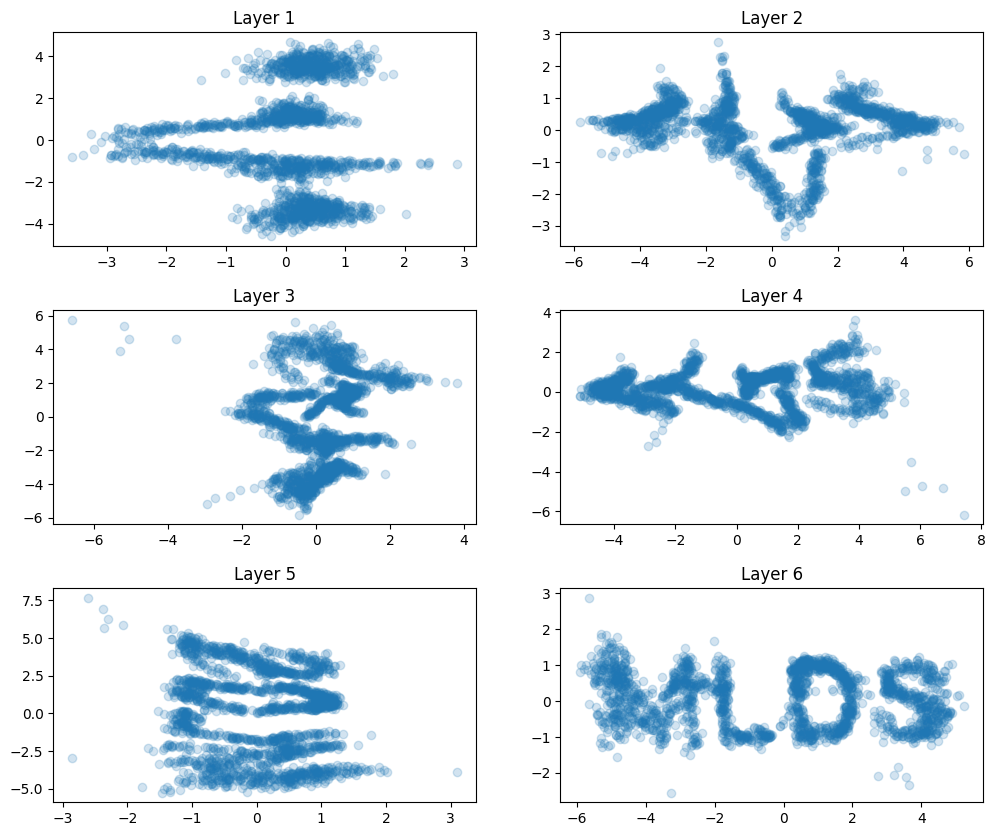

In [45]:
# Visualise the layer transformations

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.3)
for i, ax in enumerate(axes.flatten()):
    ax.set_title(f"Layer {i+1}")
    transform = maf2_transforms[i]
    ax.scatter(transform[:, 0], transform[:, 1], alpha=0.2)

Congratulations on completing this week's assignment! You have now implemented and trained a Masked Autoregressive Flow (MAF) normalising flow model on a point cloud dataset, and experimented with using different base distributions.